<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [2]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [29]:
import pyspark.sql.functions as F
from pyspark.sql.types import *


ratings_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + RATINGS_PATH)

In [4]:
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [30]:
selected_movies = ratings_df.groupby('movieId').count().filter('count >= 10').select('movieId')

ratings_df = ratings_df\
    .join(selected_movies, 'movieId')

In [31]:
ratings_df.count()

24890583

In [32]:
(ratings_df, test_ratings_df) = ratings_df.randomSplit([0.8, 0.2])

ratings_df = ratings_df.cache()
test_ratings_df = test_ratings_df.cache()

In [33]:
ratings_df.select('userId').distinct().count()

162541

In [34]:
ratings_df.select('movieId').distinct().count()

24330

In [35]:
from pyspark.ml.recommendation import ALS, ALSModel


rank = 30
maxIter = 5
regParam = 0.1
alpha = 0.5


als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, userCol='userId', itemCol='movieId',
          ratingCol='rating', coldStartStrategy='drop', numUserBlocks=10, numItemBlocks=10,
          nonnegative=True, checkpointInterval=3, implicitPrefs=True, alpha=alpha)

als_model = als.fit(ratings_df)

In [36]:
from pyspark.ml.evaluation import RegressionEvaluator


predictions = als_model.transform(test_ratings_df)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.3191516388782456


In [37]:
items = als_model.itemFactors.select(F.col('id').alias('movieId'), 'features')
users = als_model.userFactors.select(F.col('id').alias('userId'), 'features')

In [38]:
 users.count(), items.count()

(162541, 24330)

In [39]:
from functools import partial


def most_similar(vec, vecs_df, names_df, name_col, vec_column='features', id_column='movieId', top_n=20):
    def similarity(a, b):
        return float(np.dot(a, b))
    
    similarity_udf = F.udf(partial(similarity, vec), FloatType())
    
    top = vecs_df\
        .withColumn('sim', similarity_udf(F.col(vec_column)))\
        .join(names_df, id_column) \
        .sort(F.col('sim').desc())\
        .take(top_n)
    
    top = [(row[name_col], row['sim'], row[id_column]) for row in top]
        
    return top

In [40]:
movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [42]:
most_similar(items.filter(F.col('movieId') == 102125).first()['features'], 
             items, 
             movies_df,
             'title',
             top_n=20)

[('The Hunger Games (2012)', 1.015023112297058, 91500),
 ('Guardians of the Galaxy (2014)', 1.0141681432724, 112852),
 ('Captain America: The Winter Soldier (2014)', 1.0119675397872925, 110102),
 ('The Hunger Games: Catching Fire (2013)', 1.0085968971252441, 106487),
 ('Captain America: The First Avenger (2011)', 1.0078189373016357, 88140),
 ('Thor (2011)', 1.0016133785247803, 86332),
 ('Avengers, The (2012)', 1.0002464056015015, 89745),
 ('Iron Man 3 (2013)', 0.9988570213317871, 102125),
 ('Avengers: Age of Ultron (2015)', 0.9853427410125732, 122892),
 ('Iron Man 2 (2010)', 0.9761397838592529, 77561),
 ('X-Men: Days of Future Past (2014)', 0.9717006087303162, 111362),
 ('Deadpool (2016)', 0.9527263641357422, 122904),
 ('Despicable Me (2010)', 0.9508697390556335, 79091),
 ('Hobbit: An Unexpected Journey, The (2012)', 0.9472380876541138, 98809),
 ('X-Men: First Class (2011)', 0.942909300327301, 87232),
 ('The Hunger Games: Mockingjay - Part 1 (2014)', 0.9418891668319702, 116823),
 ('Fro

In [48]:
most_similar(items.filter(F.col('movieId') == 923).first()['features'], 
             items, 
             movies_df,
             'title',
             top_n=20)

[('Rear Window (1954)', 1.3324941396713257, 904),
 ('Casablanca (1942)', 1.3265633583068848, 912),
 ('Citizen Kane (1941)', 1.3114204406738281, 923),
 ('Chinatown (1974)', 1.2845097780227661, 1252),
 ('North by Northwest (1959)', 1.2814443111419678, 908),
 ('Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
  1.2698745727539062,
  750),
 ('Vertigo (1958)', 1.261254906654358, 903),
 ('Graduate, The (1967)', 1.2288837432861328, 1247),
 ('Annie Hall (1977)', 1.2281460762023926, 1230),
 ('Psycho (1960)', 1.2174863815307617, 1219),
 ("One Flew Over the Cuckoo's Nest (1975)", 1.2071822881698608, 1193),
 ('Taxi Driver (1976)', 1.1511625051498413, 111),
 ('Maltese Falcon, The (1941)', 1.14179527759552, 913),
 ('Amadeus (1984)', 1.1331160068511963, 1225),
 ('Apocalypse Now (1979)', 1.1285710334777832, 1208),
 ('2001: A Space Odyssey (1968)', 1.1115596294403076, 924),
 ('Godfather, The (1972)', 1.1109793186187744, 858),
 ('To Kill a Mockingbird (1962)', 1.102314591407

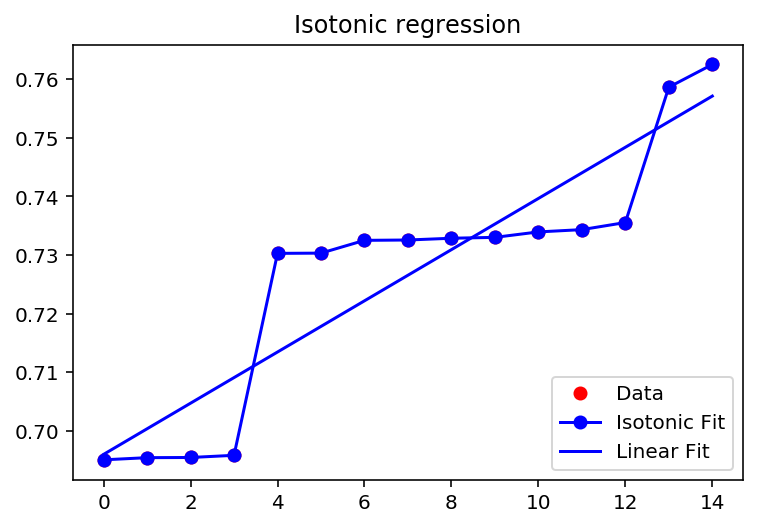

In [7]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state

n = 15
x = np.arange(n)
rs = check_random_state(0)
# y = rs.randint(-50, 50, size=(n,)) + 50. * np.log1p(np.arange(n))
y = [0.76250,
0.75863,
0.73554,
0.73433,
0.73394,
0.73301,
0.73286,
0.73256,
0.73250,
0.73032,
0.73028,
0.69583,
0.69546,
0.69543,
0.69506]
y = y[::-1]

# #############################################################################
# Fit IsotonicRegression and LinearRegression models

ir = IsotonicRegression()

y_ = ir.fit_transform(x, y)

lr = LinearRegression()
lr.fit(x[:, np.newaxis], y)  # x needs to be 2d for LinearRegression

# #############################################################################
# Plot result

segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(np.full(n, 0.5))

fig = plt.figure()
plt.plot(x, y, 'r.', markersize=12)
plt.plot(x, y_, 'b.-', markersize=12)
plt.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
plt.gca().add_collection(lc)
plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')
plt.title('Isotonic regression')
plt.show()